In [1]:
using AlgebraicStockFlow

using Catlab
using Catlab.CategoricalAlgebra
using LabelledArrays
using OrdinaryDiffEq
using Plots

using Catlab.Graphics
using Catlab.Programs
using Catlab.WiringDiagrams

In [2]:
display_uwd(ex) = to_graphviz(ex, box_labels=:name, junction_labels=:variable, edge_attrs=Dict(:len=>"1"));

# A COVID-19 composition model

We build this simplified model as the composite of three component models:
- Model A: a model of disease spread, development and hospitalization,
- Model B: a model of vaccination,
- Model C: a model of disease development for asymptomatic individuals. 

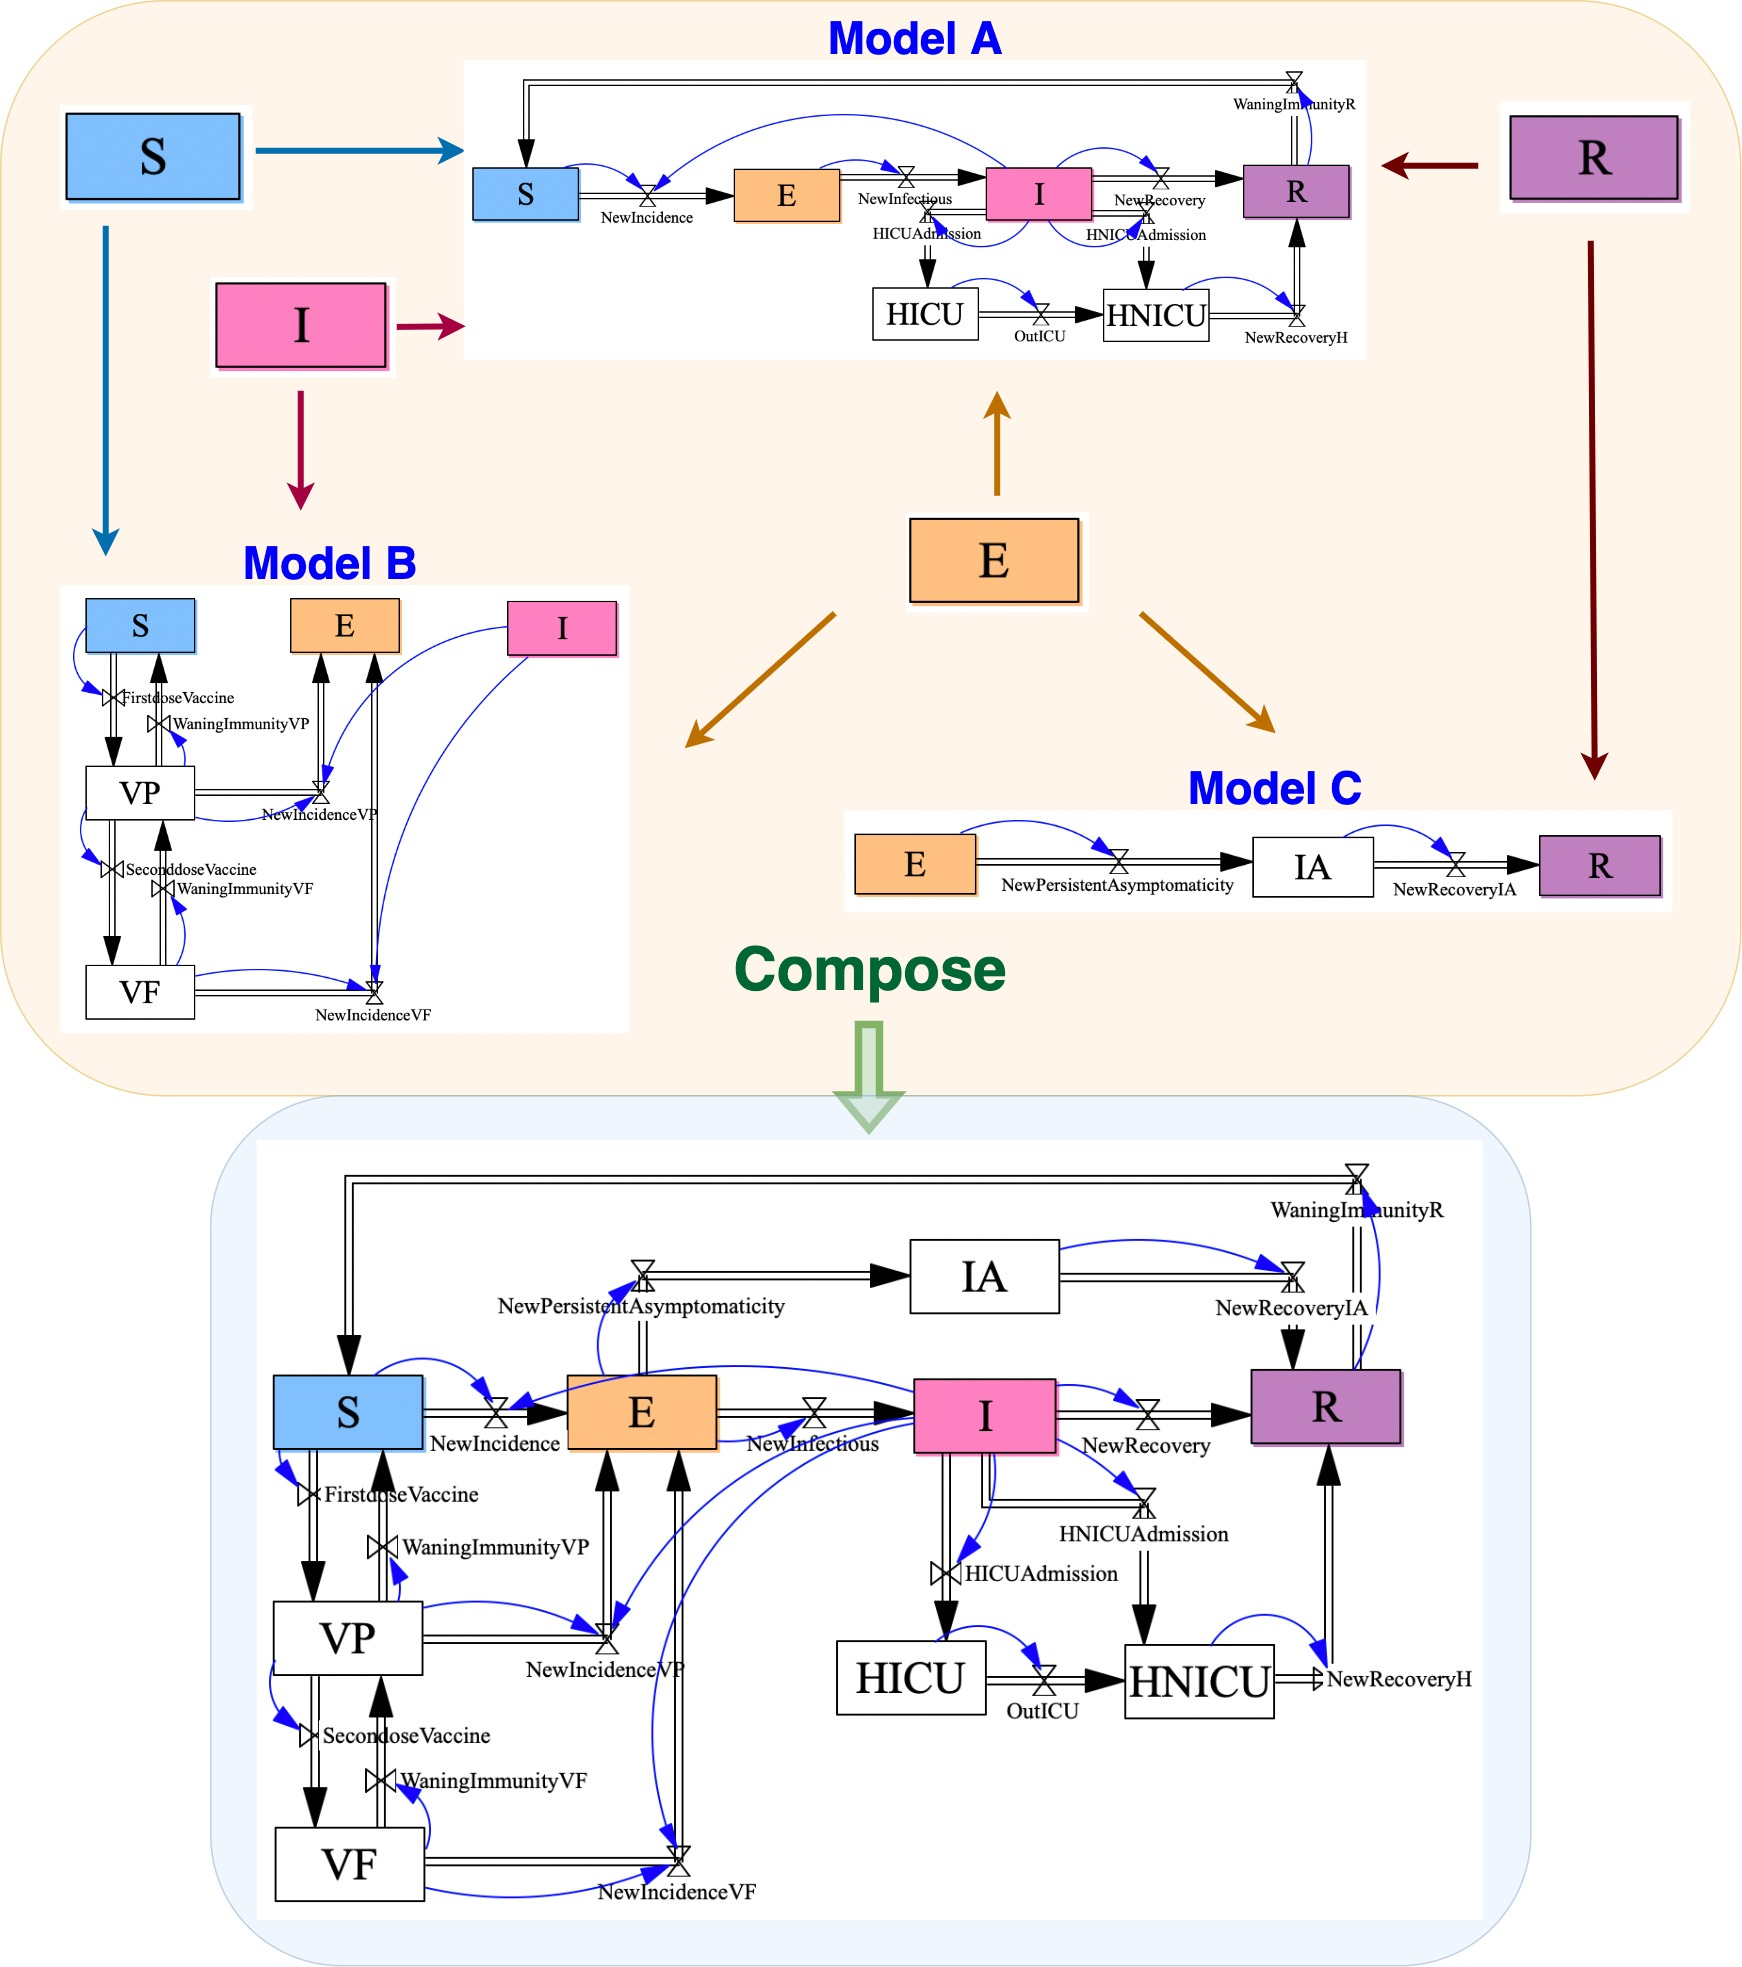
<div align="center">Figure 1

The top of the figure shows the open primitive stock-flow diagrams for three models, and the bottom shows the composed COVID-19 model composing by the stocks S,E,I,R.

The final composed COVID-19 model simulates the coronavirus disease’s
spread, development, hospitalization, and vaccination processes on a population that includes both symptomatic and asymptomatic individuals.
    
**Note**: This particular COVID-19 model is both simplified in structure and assumptions. Various features have been ignored in this simple example (e.g. the diagnosing process, deaths, and transmission of the disease from the IA stock). One reason is that the primitive stock-flow schema does not support auxiliary variables. However, full-fledged stock-flow diagrams including auxiliary variables are implemented in our StockFlow package, enabling the implementation of these additional features.

The ODEs of the composed COVID-19 model are:

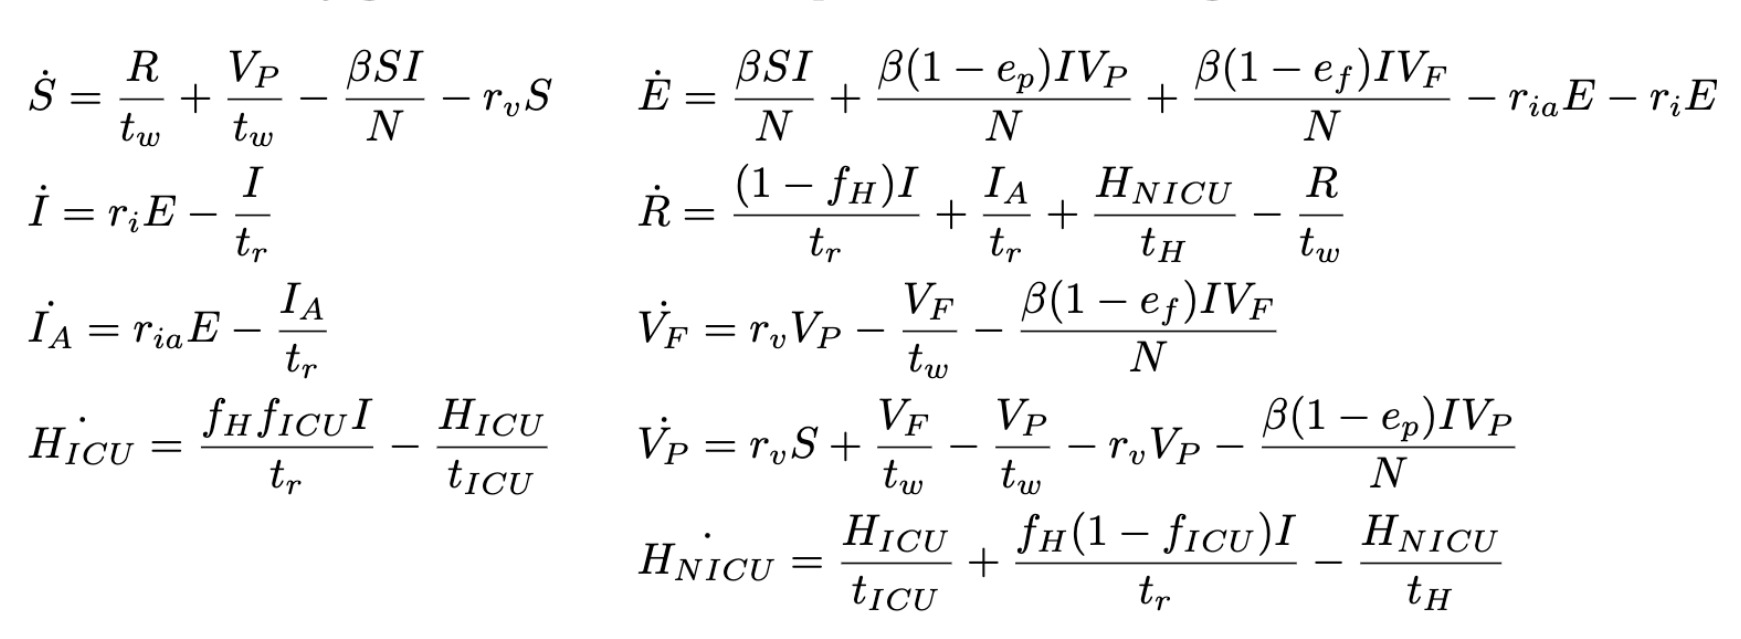

Okay, let's see how to build this COVID-19 model 

## SEIRH Model (Model A)

Model A is the SEIRH (Susceptible-Exposed-Symptomatic Infectious-Recovered-Hospitalized) model, which simulates the disease spread through the symptomatic infectious, development, and hospitalization processes. The stocks labelled “HICU” and “HNICU” represent the populations of hospitalized ICU patients and hospitalized non-ICU patients. 

To create a primitive stock-flow diagram, the user need to define the pair of:

- the function of each flow (denoted as $\phi$ in the paper)
- the instance of a primitive stock-flow diagram (denoted as $H^{FinSet}$ in the paper) using julia function "StockAndFlowp()"

In [3]:
# define functions ϕ of flows in the SEIRH model
fNewIncidence(u,p,t)=p.β*u.S*u.I/p.N
fNewInfectious(u,p,t)=u.E*p.ri
fNewRecovery(u,p,t)=u.I/p.tr * (1.0-p.fH )
fWaningImmunityR(u,p,t)=u.R/p.tw
fHICUAdmission(u,p,t) = u.I/p.tr * p.fH * p.fICU
fHNICUAdmission(u,p,t) = u.I/p.tr * p.fH * (1.0-p.fICU)
fOutICU(u,p,t) = u.HICU/p.tICU
fRecoveryH(u,p,t)= u.HNICU/p.tH

# StockAndFlowp(stocks,
#               (flow=>function, upstream=>downstream) => stocks linked)
seirh = StockAndFlowp((:S, :E, :I, :R, :HICU, :HNICU), 
   ((:NewIncidence=>fNewIncidence, :S=>:E) => (:S, :I), 
    (:NewInfectious=>fNewInfectious, :E=>:I) => :E,
    (:NewRecovery=>fNewRecovery, :I=>:R) => :I, 
    (:WaningImmunityR=>fWaningImmunityR, :R=>:S) => :R,
    (:HICUAdmission=>fHICUAdmission, :I=>:HICU) => :I, 
    (:HNICUAdmission=>fHNICUAdmission, :I=>:HNICU) => :I, 
    (:OutICU=>fOutICU, :HICU=>:HNICU) => :HICU,
    (:RecoveryH=>fRecoveryH, :HNICU=>:R) => :HNICU))

StockAndFlowp with elements Flow = 1:8, Stock = 1:6, Link = 1:9
┌──────┬───┬───┬─────────────────┬──────────────────┐
│ Flow │ u │ d │           fname │               ϕf │
├──────┼───┼───┼─────────────────┼──────────────────┤
│    1 │ 1 │ 2 │    NewIncidence │    fNewIncidence │
│    2 │ 2 │ 3 │   NewInfectious │   fNewInfectious │
│    3 │ 3 │ 4 │     NewRecovery │     fNewRecovery │
│    4 │ 4 │ 1 │ WaningImmunityR │ fWaningImmunityR │
│    5 │ 3 │ 5 │   HICUAdmission │   fHICUAdmission │
│    6 │ 3 │ 6 │  HNICUAdmission │  fHNICUAdmission │
│    7 │ 5 │ 6 │          OutICU │          fOutICU │
│    8 │ 6 │ 4 │       RecoveryH │       fRecoveryH │
└──────┴───┴───┴─────────────────┴──────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     S │
│     2 │     E │
│     3 │     I │
│     4 │     R │
│     5 │  HICU │
│     6 │ HNICU │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 3 │ 1 │
│    3 │ 2 │ 2 │
│    4 │ 3 │ 3 │
│    5 │ 4 │ 4 │
│    6 │ 3 │ 5 │
│    7 │ 3 │ 6 │
│    8 │ 5 │ 7 │
│    9 │ 6 │ 8 │
└──────┴───┴───┘

The user could also plot the primitive stock-flow diagram using the function "Graph()" built in the StockFlow.jl package (this stock-flow diagram is the same as the Model A shown in the figure 1):

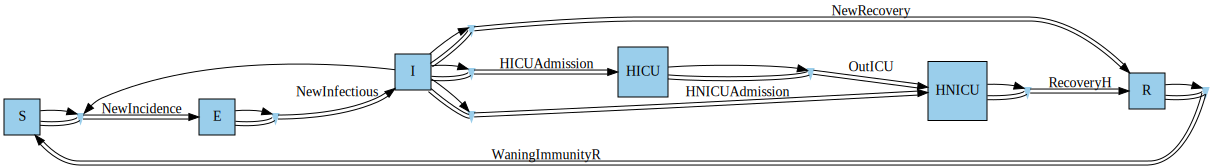

In [4]:
# Graph(primitive stock-flow model, direction of the diagram - the default value is "LR" from left to right; 
# users could also use "TB" from top to bottom)
Graph(seirh)

## Vaccine Model (Model B)
Model B simulates the vaccination process. The stock “VP” represents individuals who are partially vaccinated, because they have only received the first dose of the vaccine or immunity from vaccination has decrease. In contrast, the stock “VF” represents individuals who are fully vaccinated having received two doses of the vaccine or immunity from vaccination has increase due to boosters. Notably, both partially and fully vaccinated individuals are not fully protected from transmitting the disease. Thus, there are flows from stock “VP” and “VF” to “E” that represents the new infection of vaccinated individuals.

In [5]:
# define functions ϕ of flows in the Vaccine model
fFirstdoseVaccine(u,p,t) = u.S * p.rv
fSeconddoseVaccine(u,p,t) = u.VP * p.rv
fWaningImmunityVP(u,p,t) = u.VP / p.tw
fWaningImmunityVF(u,p,t) = u.VF / p.tw
fNewIncidenceVP(u,p,t) = p.β*u.VP*u.I*(1.0-p.eP)/p.N
fNewIncidenceVF(u,p,t) = p.β*u.VF*u.I*(1.0-p.eF)/p.N

# Stock and flow diagram of Vaccine model
v = StockAndFlowp((:S, :E, :I, :VP, :VF), 
   ((:FirstdoseVaccine=>fFirstdoseVaccine, :S=>:VP) => :S, 
    (:SeconddoseVaccine=>fSeconddoseVaccine, :VP=>:VF) => :VP, 
    (:WaningImmunityVP=>fWaningImmunityVP, :VP=>:S) => :VP,
    (:WaningImmunityVF=>fWaningImmunityVF, :VF=>:VP) => :VF,
    (:NewIncidenceVP=>fNewIncidenceVP, :VP=>:E) => (:VP, :I),
    (:NewIncidenceVF=>fNewIncidenceVF, :VF=>:E) => (:VF, :I)))

StockAndFlowp with elements Flow = 1:6, Stock = 1:5, Link = 1:8
┌──────┬───┬───┬───────────────────┬────────────────────┐
│ Flow │ u │ d │             fname │                 ϕf │
├──────┼───┼───┼───────────────────┼────────────────────┤
│    1 │ 1 │ 4 │  FirstdoseVaccine │  fFirstdoseVaccine │
│    2 │ 4 │ 5 │ SeconddoseVaccine │ fSeconddoseVaccine │
│    3 │ 4 │ 1 │  WaningImmunityVP │  fWaningImmunityVP │
│    4 │ 5 │ 4 │  WaningImmunityVF │  fWaningImmunityVF │
│    5 │ 4 │ 2 │    NewIncidenceVP │    fNewIncidenceVP │
│    6 │ 5 │ 2 │    NewIncidenceVF │    fNewIncidenceVF │
└──────┴───┴───┴───────────────────┴────────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     S │
│     2 │     E │
│     3 │     I │
│     4 │    VP │
│     5 │    VF │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 4 │ 2 │
│    3 │ 4 │ 3 │
│    4 │ 5 │ 4 │
│    5 │ 4 │ 5 │
│    6 │ 3 │ 5 │
│    7 │ 5 │ 6 │
│    8 │ 3 │ 6 │
└──────┴───┴───┘

Plot the same primitive stock-flow diagram in StockFlow.jl package (this stock-flow diagram is the same as the Model B shown in the figure 1):

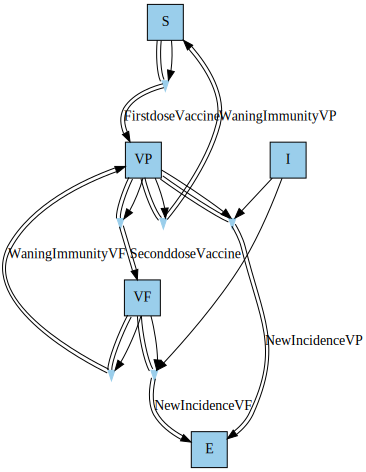

In [6]:
Graph(v,"TB")

## Persistent Asymptomaticity Model (Model C)
Model C simulates a disease developmental process for individuals who are persistently asymptomatic. The stock “IA” indicates the infected individuals without any symptoms.

In [7]:
# define functions ϕ of flows in the Persist Asymptomaticity model
fNewPersistentAsymptomaticity(u,p,t) = u.E * p.ria
fNewRecoveryIA(u,p,t) = u.IA / p.tr

# Stock and flow diagram of Persistent Asymptomaticity Model
ia = StockAndFlowp((:E, :IA, :R), 
   ((:NewPersistentAsymptomaticity=>fNewPersistentAsymptomaticity, :E=>:IA) => :E, 
    (:NewRecoveryIA=>fNewRecoveryIA, :IA=>:R) => :IA))

StockAndFlowp with elements Flow = 1:2, Stock = 1:3, Link = 1:2
┌──────┬───┬───┬──────────────────────────────┬───────────────────────────────┐
│ Flow │ u │ d │                        fname │                            ϕf │
├──────┼───┼───┼──────────────────────────────┼───────────────────────────────┤
│    1 │ 1 │ 2 │ NewPersistentAsymptomaticity │ fNewPersistentAsymptomaticity │
│    2 │ 2 │ 3 │                NewRecoveryIA │                fNewRecoveryIA │
└──────┴───┴───┴──────────────────────────────┴───────────────────────────────┘
┌───────┬───────┐
│ Stock │ sname │
├───────┼───────┤
│     1 │     E │
│     2 │    IA │
│     3 │     R │
└───────┴───────┘
┌──────┬───┬───┐
│ Link │ s │ t │
├──────┼───┼───┤
│    1 │ 1 │ 1 │
│    2 │ 2 │ 2 │
└──────┴───┴───┘

Plot the same primitive stock-flow diagram in StockFlow.jl package (this stock-flow diagram is the same as the Model C shown in the figure 1):

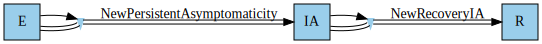

In [8]:
Graph(ia)

## Composition
Define the UWD-algebra:

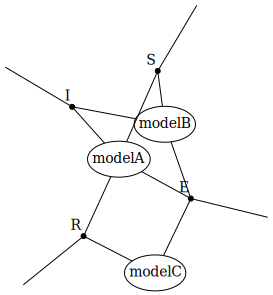

In [9]:
covid = @relation (S, E, I, R) begin
    modelA(S,E,I,R)
    modelB(S,E,I)
    modelC(E,R)
end;
display_uwd(covid)

Compose the three open stock-flow diagrams (Model A, Model B, Model C) by applying the UWD-algebra, we can generate the open stock-flow diagram of the composed COVID-19 model. The apex is the COVID-19 stock-flow diagram. 

In [10]:
# Open three Stock and Flow Diagrams
openseirh = Open(seirh, [:S], [:E], [:I], [:R])
openv = Open(v, [:S], [:E], [:I])
openia = Open(ia, [:E], [:R])
# Compose those three models according the UWD-algebra
openCOVID19 = oapply(covid, [openseirh, openv, openia])
# Generate the composed model (Stock and Flow Diagram)
COVID19 = apex(openCOVID19)

Flow,u,d,fname,ϕf
1,1,2,NewIncidence,fNewIncidence
2,2,3,NewInfectious,fNewInfectious
3,3,4,NewRecovery,fNewRecovery
4,4,1,WaningImmunityR,fWaningImmunityR
5,3,5,HICUAdmission,fHICUAdmission
6,3,6,HNICUAdmission,fHNICUAdmission
7,5,6,OutICU,fOutICU
8,6,4,RecoveryH,fRecoveryH
9,1,7,FirstdoseVaccine,fFirstdoseVaccine
10,7,8,SeconddoseVaccine,fSeconddoseVaccine


Plot the same primitive stock-flow diagram in StockFlow.jl package (this stock-flow diagram is the same as the composed model - bottom one - shown in the figure 1)::

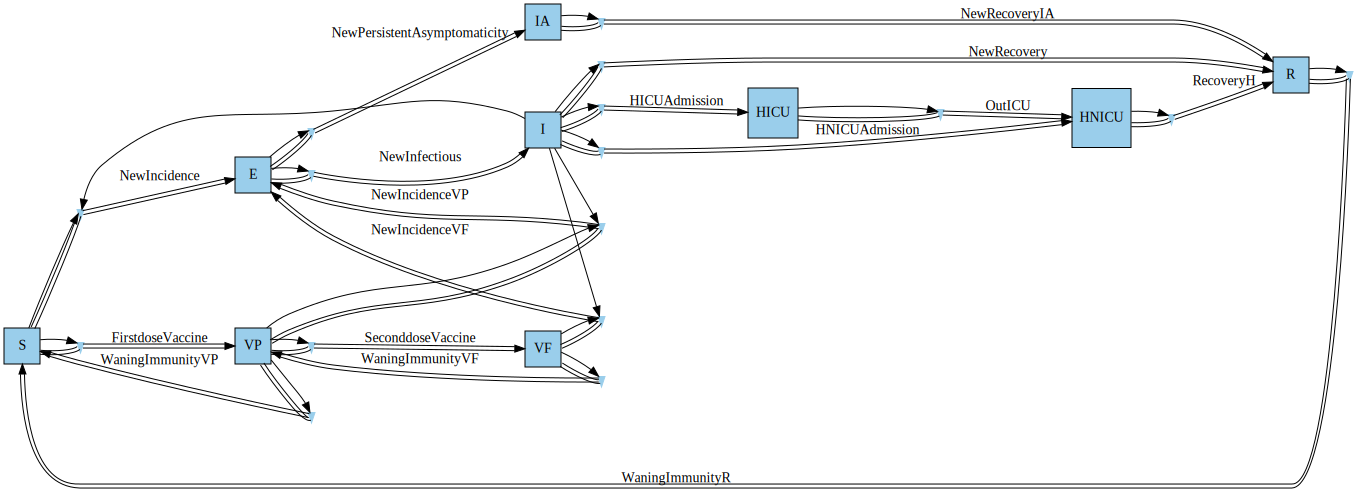

In [11]:
Graph(COVID19)

The constant parameters and the initial values of each stock are defined seperately from the primitive stock-flow diagram. This design enables the users to define multiple scenarios of the same dynamical system flexibly. For example, the parameter values used in this example are from Canada’s population. We can efficiently run the COVID-19 model on other populations (e.g., the United States) by replacing the parameter values.

The meaning of each constant parameter is listed as follows:
- $\beta$: contact rate per day $\times$ transmission probability
- N: total population
- $t_r$: mean days of COVID-19 infectives progressing to the next stage, including recovery or hospitalized.
- $t_w$: mean days of waningwanning immunity
- $f_H$: fraction of the symptomatics proceeding on to hospitalization
- $f_{ICU}$: fraction of the hospitalization to ICU
- $t_{ICU}$: mean days of the COVID-19 patients in ICU before to non-ICU
- $t_H$: mean days of the COVID-19 patients in hospitalized non-ICU before recovered
- $r_v$: vaccination rate per day
- $e_p$: patially vaccination (first dose or of equal vaccine immumity level) vaccination efficacy
- $e_F$: fully vaccination (two doses or of equal vaccine immumity level) vaccination efficacy
- $r_i$: daily rate of the exposed individuals to the symptomatics infectious
- $r_{ia}$: daily rate of the exposed individuals to the asymptomatics

In [12]:
# define constant parameters
p_COVID19 = LVector(
    β=0.8, N=38010001.0, tr=12.22, tw=2*365.0,
    fH=0.002, fICU=0.23, tICU=6.0, tH = 12.0,
    rv=0.01, eP=0.6, eF=0.85, ri=0.207, ria=0.138  
)
# define initial values for stocks
u0_COVID19 = LVector(
    S=38010000.0, E=0.0, I=1.0, IA=0.0, R=0.0, HICU=0.0, HNICU=0.0, VP=0.0, VF=0.0
)

9-element LArray{Float64, 1, Vector{Float64}, (:S, :E, :I, :IA, :R, :HICU, :HNICU, :VP, :VF)}:
     :S => 3.801e7
     :E => 0.0
     :I => 1.0
    :IA => 0.0
     :R => 0.0
  :HICU => 0.0
 :HNICU => 0.0
    :VP => 0.0
    :VF => 0.0

Before calculate the ODEs, we need to Check the dependancies of the links first. The julia function "checkfls()" checks possible bugs for functions of all flows of:
- if some stocks are linked to a flow, but not been used in the function of the flow
- if some stocks are used in the function of a flow but not linked to it

In [13]:
# check the dependencies of links of all flows' functions
checkfls(COVID19, u0_COVID19, p_COVID19)

"Great! Links dependency check passed!"

Now, we can use the function "ODEProblem()" to calculate the ODEs of the stock-flow diagram COVID19 generated. The julia function "vectorfield()" aims to convert stock-flow diagrams (e.g., COVID19) to ODEs:

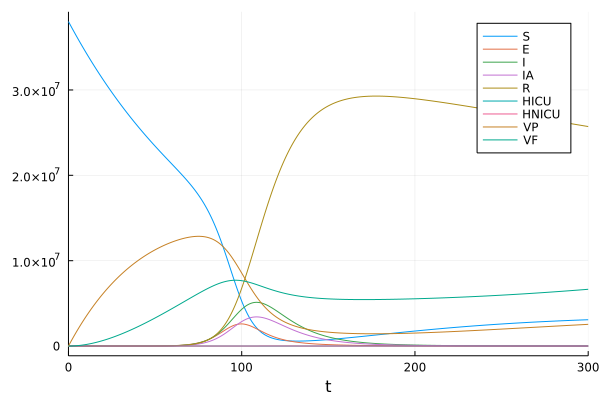

In [14]:
# solve the ODEs
prob_COVID19 = ODEProblem(vectorfield(COVID19),u0_COVID19,(0.0,300.0),p_COVID19);
sol_COVID19 = solve(prob_COVID19,Tsit5(),abstol=1e-8);
plot(sol_COVID19)

## Post-processing of flow functions calculation
after generate the results of the state (stocks) of a dynamical system, we can calculate the functions of the state (e.g., functions of flows, or interested variable -- like IA+I). The following codes show how to calculate the flow of "FirstdoseVaccine":

In [15]:
# Flow of FirstdoseVaccine
ϕFirstdoseVaccine = map(x->fFirstdoseVaccine(sol_COVID19.u[x],p_COVID19,sol_COVID19.t[x]),collect(1:length(sol_COVID19.t)))

73-element Vector{Float64}:
 380100.0
 380099.9999998586
 380099.9999984444
 380099.9999843023
 380099.99984288134
 380099.9984286719
 380099.98428657756
 380099.84286566736
 380098.4286598555
 380084.28693077463
 379948.3492319071
 379584.8942530458
 378908.33173198055
      ⋮
  21686.96555045558
  22848.179536130483
  23950.92421646365
  24993.702641597043
  25975.606652367256
  26896.203352935998
  27755.49516342795
  28553.881133585117
  29292.127628470775
  29971.342232470415
  30592.946593146655
  30842.079132238272